# Data Cleaning and Prep

In [732]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' #This line is necessary on macbook s.t. models compile

plt.style.use('seaborn-colorblind')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [733]:
# Import the data, here I had to import 3 different csvs due to the available download
df1 = pd.read_csv('Good Data/S&P 500 Historical Data (1).csv')
df2 = pd.read_csv('Good Data/S&P 500 Historical Data (2).csv')
df3 = pd.read_csv('Good Data/S&P 500 Historical Data (3).csv')

In [734]:
df1.tail()

,Date,Price,Open,High,Low,Vol.,Change %
4994,01/01/1980,107.90,107.90,107.90,107.90,NaN,0.00%
4995,31/12/1979,107.90,107.90,108.50,107.30,NaN,0.09%
4996,28/12/1979,107.80,107.80,108.60,107.20,NaN,-0.19%
4997,27/12/1979,108.00,108.00,108.50,107.10,NaN,0.19%
4998,26/12/1979,107.80,107.80,108.40,107.10,NaN,0.09%


In [735]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(4999, 7)
(5000, 7)
(867, 7)


In [736]:
# Merge all tables
df = pd.concat([df3, df2, df1], axis = 0, join = 'outer')

In [737]:
print(df.shape)

(10866, 7)


In [738]:
# Checking the format of the table
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,23/01/2023,"4,013.35","3,980.60","4,039.63","3,969.70",NaN,1.03%
1,20/01/2023,"3,972.61","3,909.04","3,972.96","3,897.86",NaN,1.89%
2,19/01/2023,"3,898.85","3,911.84","3,922.94","3,885.54",NaN,-0.76%
3,18/01/2023,"3,928.86","4,002.25","4,014.16","3,926.59",NaN,-1.56%
4,17/01/2023,"3,990.97","3,999.28","4,015.39","3,984.57",NaN,-0.20%
5,13/01/2023,"3,999.09","3,960.60","4,003.95","3,947.67",NaN,0.40%
6,12/01/2023,"3,983.17","3,977.57","3,997.76","3,937.56",NaN,0.34%
7,11/01/2023,"3,969.61","3,932.35","3,970.07","3,928.54",NaN,1.28%
8,10/01/2023,"3,919.25","3,888.57","3,919.83","3,877.29",NaN,0.70%
9,09/01/2023,"3,892.09","3,910.82","3,950.57","3,890.42",NaN,-0.08%


In [739]:
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y', errors = 'coerce')

# Sort by values, date ascending
df = df.sort_values(by = 'Date')

In [740]:
# Drop bad data
df = df.drop(df[df["Price"]==0].index)
df = df.drop('High', axis = 1)
df = df.drop('Low', axis = 1)
df = df.drop('Vol.', axis = 1)
df = df.drop('Change %', axis = 1)

# Set index to be date ascending
df = df.set_index('Date')

# Rename columns
df = df.rename(columns={'Price': 'close'})
df = df.rename(columns={'Open': 'open'})

In [741]:
df.head()

,close,open
Date,,
1979-12-26,107.80,107.80
1979-12-27,108.00,108.00
1979-12-28,107.80,107.80
1979-12-31,107.90,107.90
1980-01-01,107.90,107.90


In [742]:
# Shift Open column up by one, so that you can also use the open price to predict the close price of that day
df['open'] = df['open'].shift(1)

In [743]:
# Count NaN values in each column
nan_counts = df.isna().sum()

for col, count in nan_counts.items():
    print(f'{col}: {count}')

close: 0
open: 1


In [744]:
df = df.dropna()

# Remove commas as this causes error when convert to float
df['close'] = df['close'].str.replace(',','')
df['open'] = df['open'].str.replace(',','')

# Convert these columns to float so that they can be parsed
df['close'] = df['close'].astype(float)
df['open'] = df['open'].astype(float)

In [745]:
# Calculate the percent change and the daily returns
df['gradient'] = (df['close'].shift(1) - df['close']) / df['close'].shift(1)
df['returns'] = df['gradient'] * 100

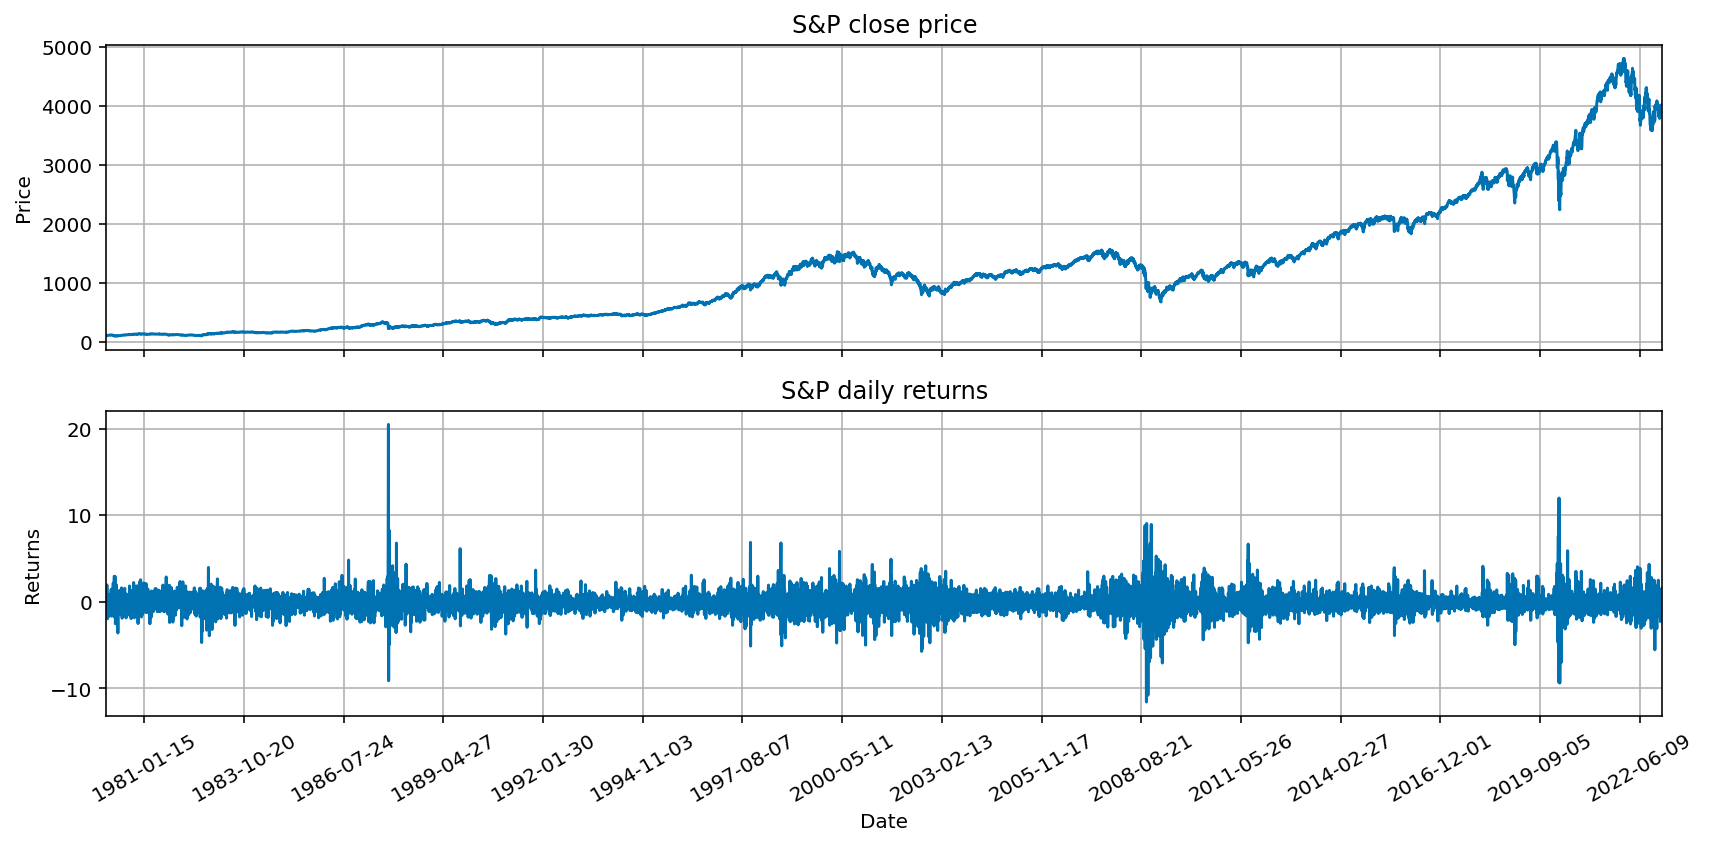

In [746]:
# Plot our results to ensure there are no outliers
df = df.dropna()

fig, ax = plt.subplots(2,1, sharex=True, figsize=(12,6))

ax[0].plot(df['close'], label = 'Ticket')
ax[0].set(title = 'S&P close price', ylabel = 'Price')
ax[0].grid(True)

ax[1].plot(df['returns'], label = 'Daily Returns')
ax[1].set(title = 'S&P daily returns', ylabel = 'Returns', xlabel = 'Date')
ax[1].grid(True)

plt.xlim(left = df.index[0])
plt.xlim(right = df.index[-1])
plt.xticks(rotation = 30)
plt.gca().xaxis.set_major_locator(MultipleLocator(1008))
plt.tight_layout();

In [747]:
# Include SMA 30, 50, 70 and EMA 30, 50, 70
df['SMA50'] = df['close'].rolling(50).mean()
df['SMA70'] = df['close'].rolling(70).mean()
df['SMA30'] = df['close'].rolling(30).mean()

df['EMA30'] = df['close'].ewm(span = 30, adjust = False). mean()
df['EMA50'] = df['close'].ewm(span = 50, adjust = False). mean()
df['EMA70'] = df['close'].ewm(span = 70, adjust = False). mean()

In [748]:
# We import these technical indicators to help us predict
from talib import RSI, BBANDS

In [749]:
#Using RSI and BBbands as technical indicators
df['rsi'] = RSI(df['close'])

high, mid, low = BBANDS(df['close'], timeperiod = 50)

df = df.join(pd.DataFrame({'bb_high': high, 'bb_low': low}, index = df.index))

In [751]:
df = df.dropna()

In [752]:
df.shape

(10799, 13)

In [753]:
# Split data into training and test sets, we will do the same but with validation comes later
training_data = df[:8639]
test_data = df[8639:]

In [754]:
# Create standard scaler
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(training_data)

# Standardize the training and test data
training_scaled = scaler.fit_transform(training_data)
testing_scaled = scaler.fit_transform(test_data)

<function matplotlib.pyplot.show(close=None, block=None)>

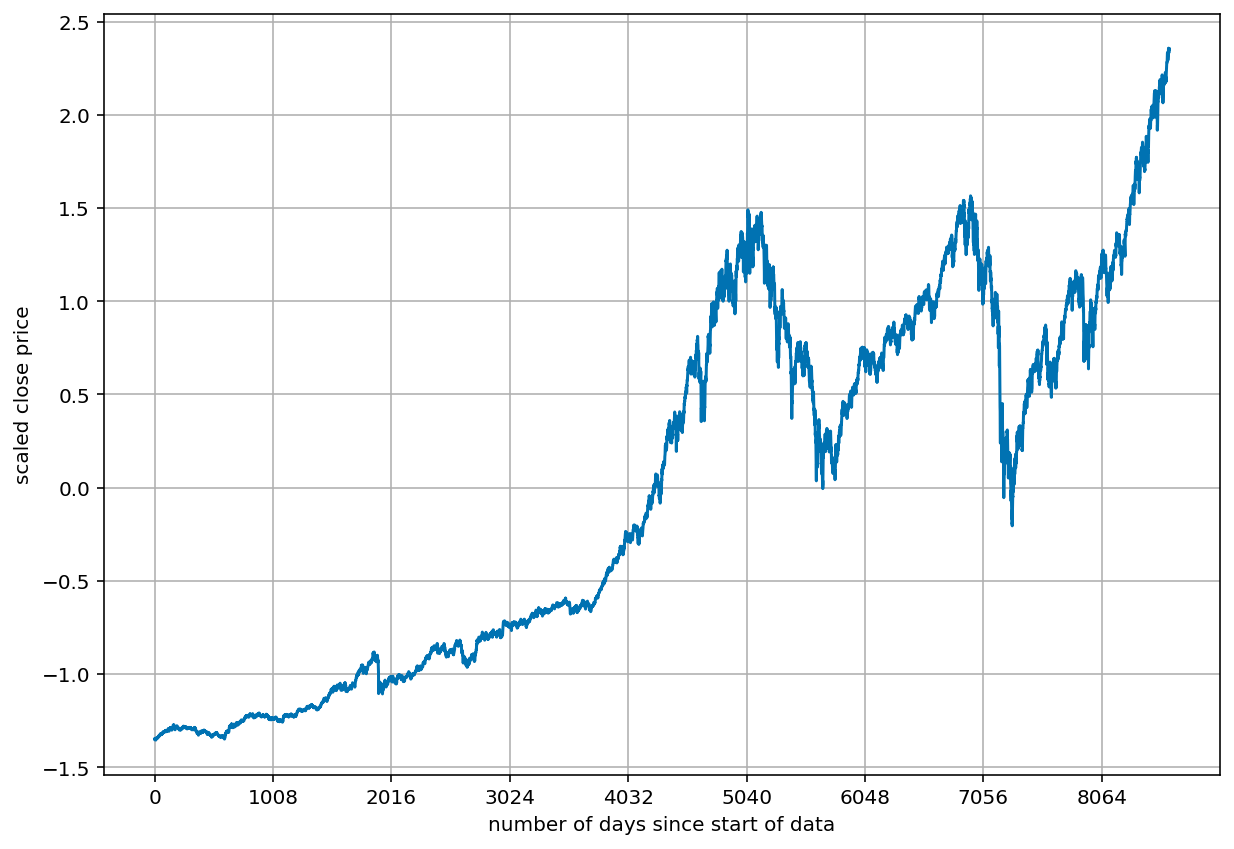

In [755]:
# Plot standard scaled close prices
plt.subplots(figsize = (10,7))
plt.plot(training_scaled[:,0])
plt.xlabel('number of days since start of data')
plt.ylabel('scaled close price')
plt.gca().xaxis.set_major_locator(MultipleLocator(1008))
plt.grid(True)
plt.show

# Prediction Modelling

In [756]:
# Create the training data
X_train, y_train = [], []

time_step = 50

length_train = 8639 # length data * 0.8

# This step is necessary to pass into a RNN
for i in range(time_step, length_train):
    X_train.append(training_scaled[i - time_step : i, :])
    y_train.append(training_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [757]:
# Creating the test data
X_test, y_test = [], []

length_train = test_data.shape[0]

for i in range(time_step, length_train):
    X_test.append(testing_scaled[i - time_step : i, :])
    y_test.append(testing_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [758]:
print(X_train.shape)
print(y_train.shape)

(8589, 50, 13)
(8589,)


In [759]:
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (-1,1))

In [299]:
# Define the model
model = Sequential([
    SimpleRNN(100, return_sequences = True),
    SimpleRNN(100, return_sequences = True),
    SimpleRNN(100),
    Dense(1)
])

# We are using three layers of simpleRNN, and a single dense output layer, as we only want to output the close price 

In [715]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 50, 100)           11400     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 50, 100)           20100     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 51,701
Trainable params: 51,701
Non-trainable params: 0
_________________________________________________________________


In [301]:
# Define some model parameters
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [303]:
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

In [304]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
269/269 [==============================] - 8s 18ms/step - loss: 0.0359 - accuracy: 0.0000e+00
Epoch 2/100
269/269 [==============================] - 5s 18ms/step - loss: 0.0028 - accuracy: 0.0000e+00
Epoch 3/100
269/269 [==============================] - 5s 19ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 4/100
269/269 [==============================] - 5s 18ms/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 5/100
269/269 [==============================] - 5s 18ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 6/100
269/269 [==============================] - 5s 18ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 7/100
269/269 [==============================] - 5s 18ms/step - loss: 0.0019 - accuracy: 0.0000e+00
Epoch 8/100
269/269 [==============================] - 5s 18ms/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 9/100
269/269 [==============================] - 5s 20ms/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 10/100
269/269 [========================

Epoch 76/100
269/269 [==============================] - 5s 18ms/step - loss: 6.5938e-04 - accuracy: 0.0000e+00
Epoch 77/100
269/269 [==============================] - 5s 18ms/step - loss: 7.3166e-04 - accuracy: 0.0000e+00
Epoch 78/100
269/269 [==============================] - 5s 19ms/step - loss: 6.5676e-04 - accuracy: 0.0000e+00
Epoch 79/100
269/269 [==============================] - 5s 19ms/step - loss: 6.9009e-04 - accuracy: 0.0000e+00
Epoch 80/100
269/269 [==============================] - 5s 18ms/step - loss: 6.7362e-04 - accuracy: 0.0000e+00
Epoch 81/100
269/269 [==============================] - 5s 19ms/step - loss: 6.3370e-04 - accuracy: 0.0000e+00
Epoch 82/100
269/269 [==============================] - 5s 18ms/step - loss: 7.0330e-04 - accuracy: 0.0000e+00
Epoch 83/100
269/269 [==============================] - 5s 18ms/step - loss: 7.0013e-04 - accuracy: 0.0000e+00
Epoch 84/100
269/269 [==============================] - 5s 18ms/step - loss: 6.7648e-04 - accuracy: 0.0000e+00
E

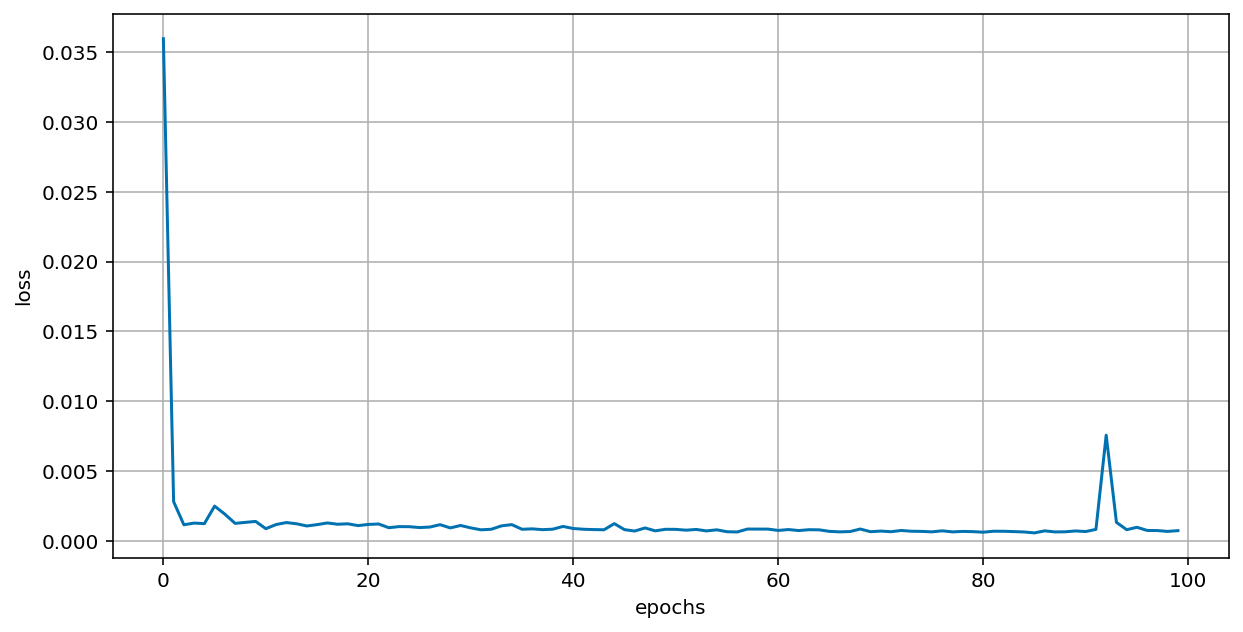

In [760]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.show()

In [761]:
testing_scaled.shape

(2160, 13)

In [312]:
model.evaluate(X_test, y_test)

66/66 [==============================] - 1s 7ms/step - loss: 0.0042 - accuracy: 0.0000e+00


[0.004197621718049049, 0.0]

In [762]:
y_pred = model.predict(X_train)

# create empty table with 13 fields (same number of columns)
y_pred_dataset_like = np.zeros(shape=(len(y_pred), 13) )

# put the predicted values in the right field
y_pred_dataset_like[:,0] = y_pred[:,0]
# inverse transform and then select the right field
y_pred = scaler.inverse_transform(y_pred_dataset_like)[:,0]

y_pred = np.reshape(y_pred, (y_pred.shape[0],1))

print(y_pred.shape)

269/269 [==============================] - 2s 7ms/step
(8589, 1)


In [763]:
# create empty table with 13 fields
y_train_dataset_like = np.zeros(shape=(len(y_train), 13) )

# put the predicted values in the right field
y_train_dataset_like[:,0] = y_train[:,0]
# inverse transform and then select the right field
y_train = scaler.inverse_transform(y_train_dataset_like)[:,0]

y_train = np.reshape(y_train, (y_train.shape[0],1))

print(y_train.shape)

(8589, 1)


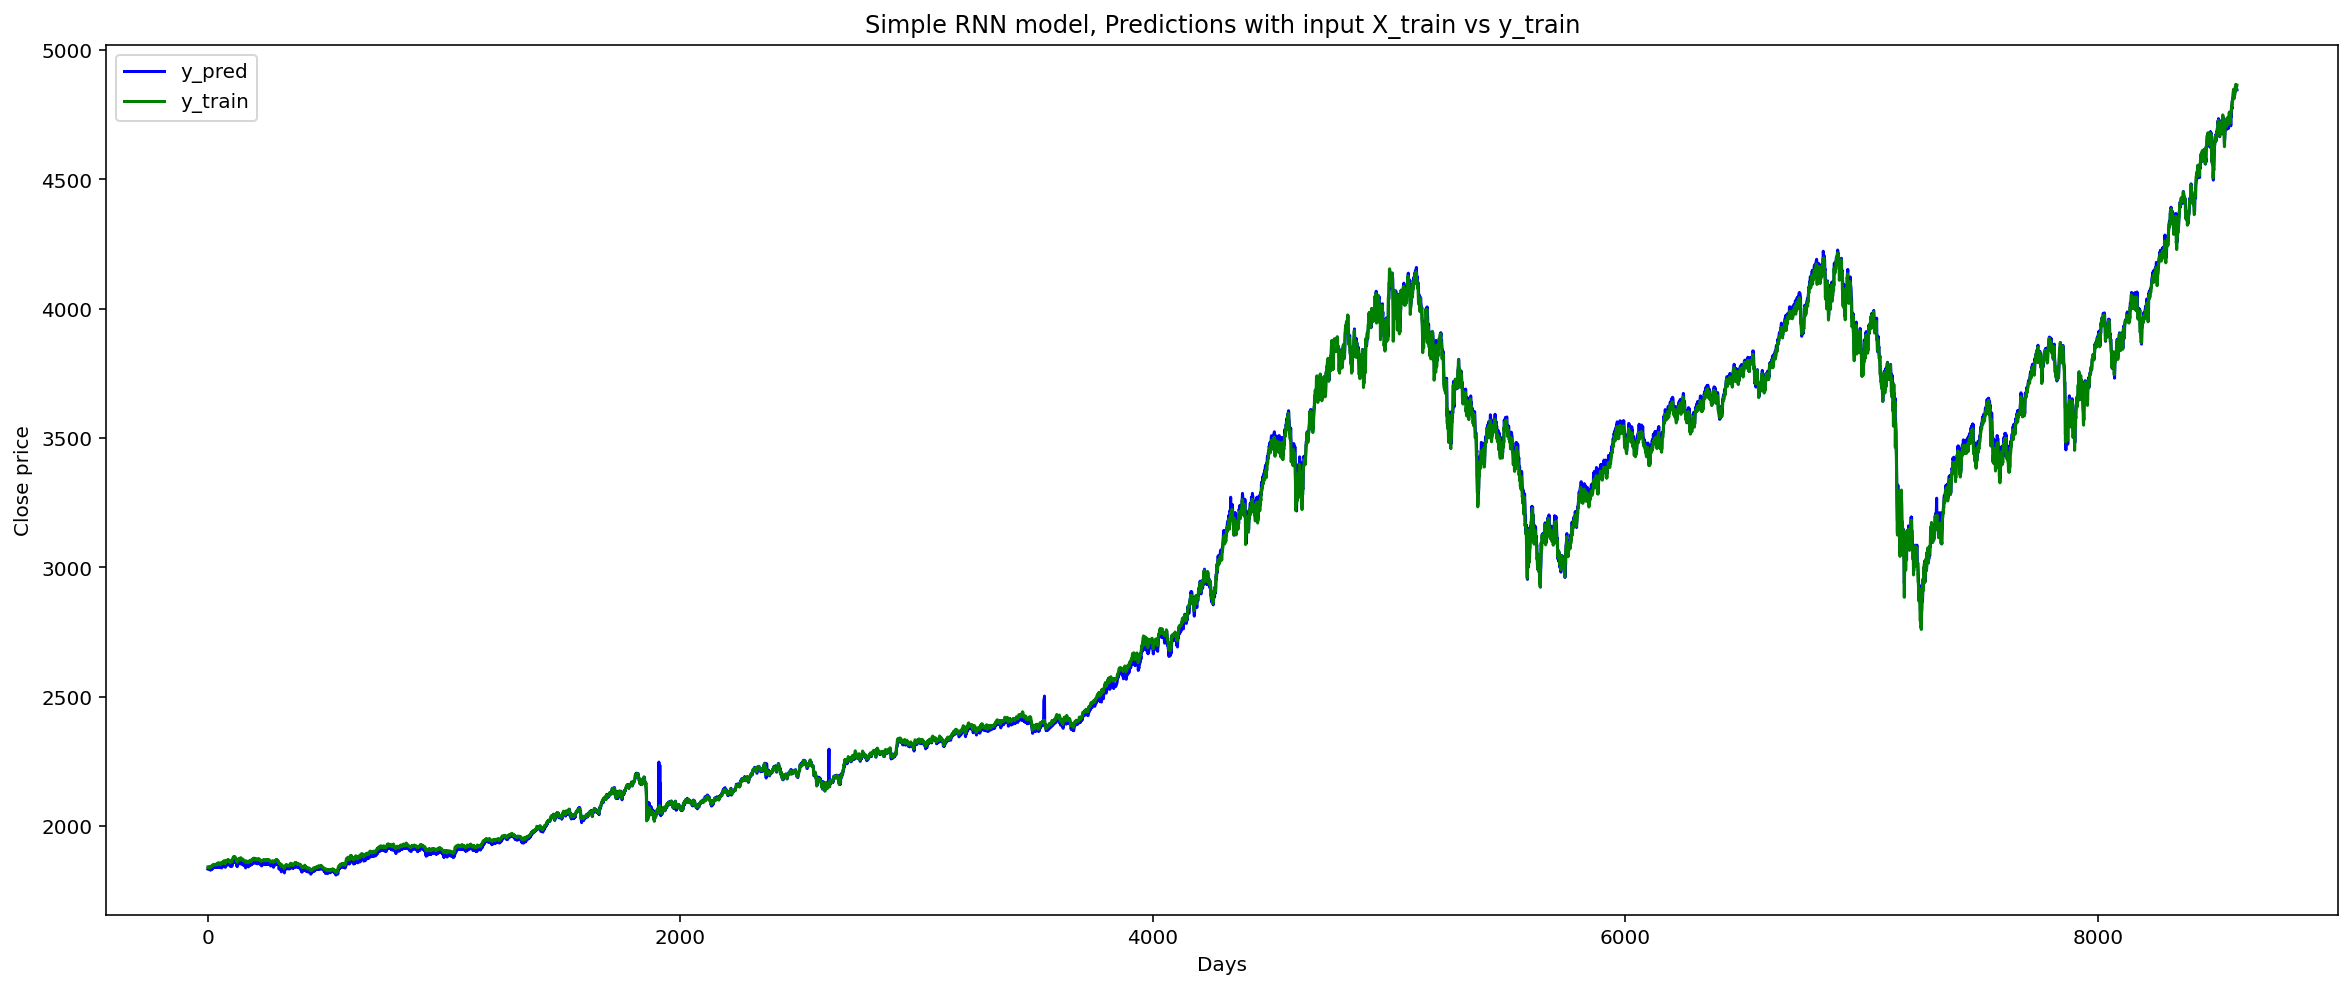

In [870]:
plt.figure(figsize = (20,8))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [765]:
y_pred_on_test = model.predict(X_test)
y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

66/66 [==============================] - 0s 7ms/step


In [766]:
# create empty table with 13 fields
y_test_pred_dataset_like = np.zeros(shape=(len(y_pred_on_test), 13))

# put the predicted values in the right field
y_test_pred_dataset_like[:,0] = y_pred_on_test[:,0]
# inverse transform and then select the right field
y_pred_on_test = scaler.inverse_transform(y_test_pred_dataset_like)[:,0]

y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

print(y_pred_on_test.shape)

(2110, 1)


In [767]:
# create empty table with 13 fields
y_test_dataset_like = np.zeros(shape=(len(y_test), 13))

# put the predicted values in the right field
y_test_dataset_like[:,0] = y_test[:,0]
# inverse transform and then select the right field
y_test = scaler.inverse_transform(y_test_dataset_like)[:,0]

y_test = np.reshape(y_test, (-1,1))

print(y_test.shape)

(2110, 1)


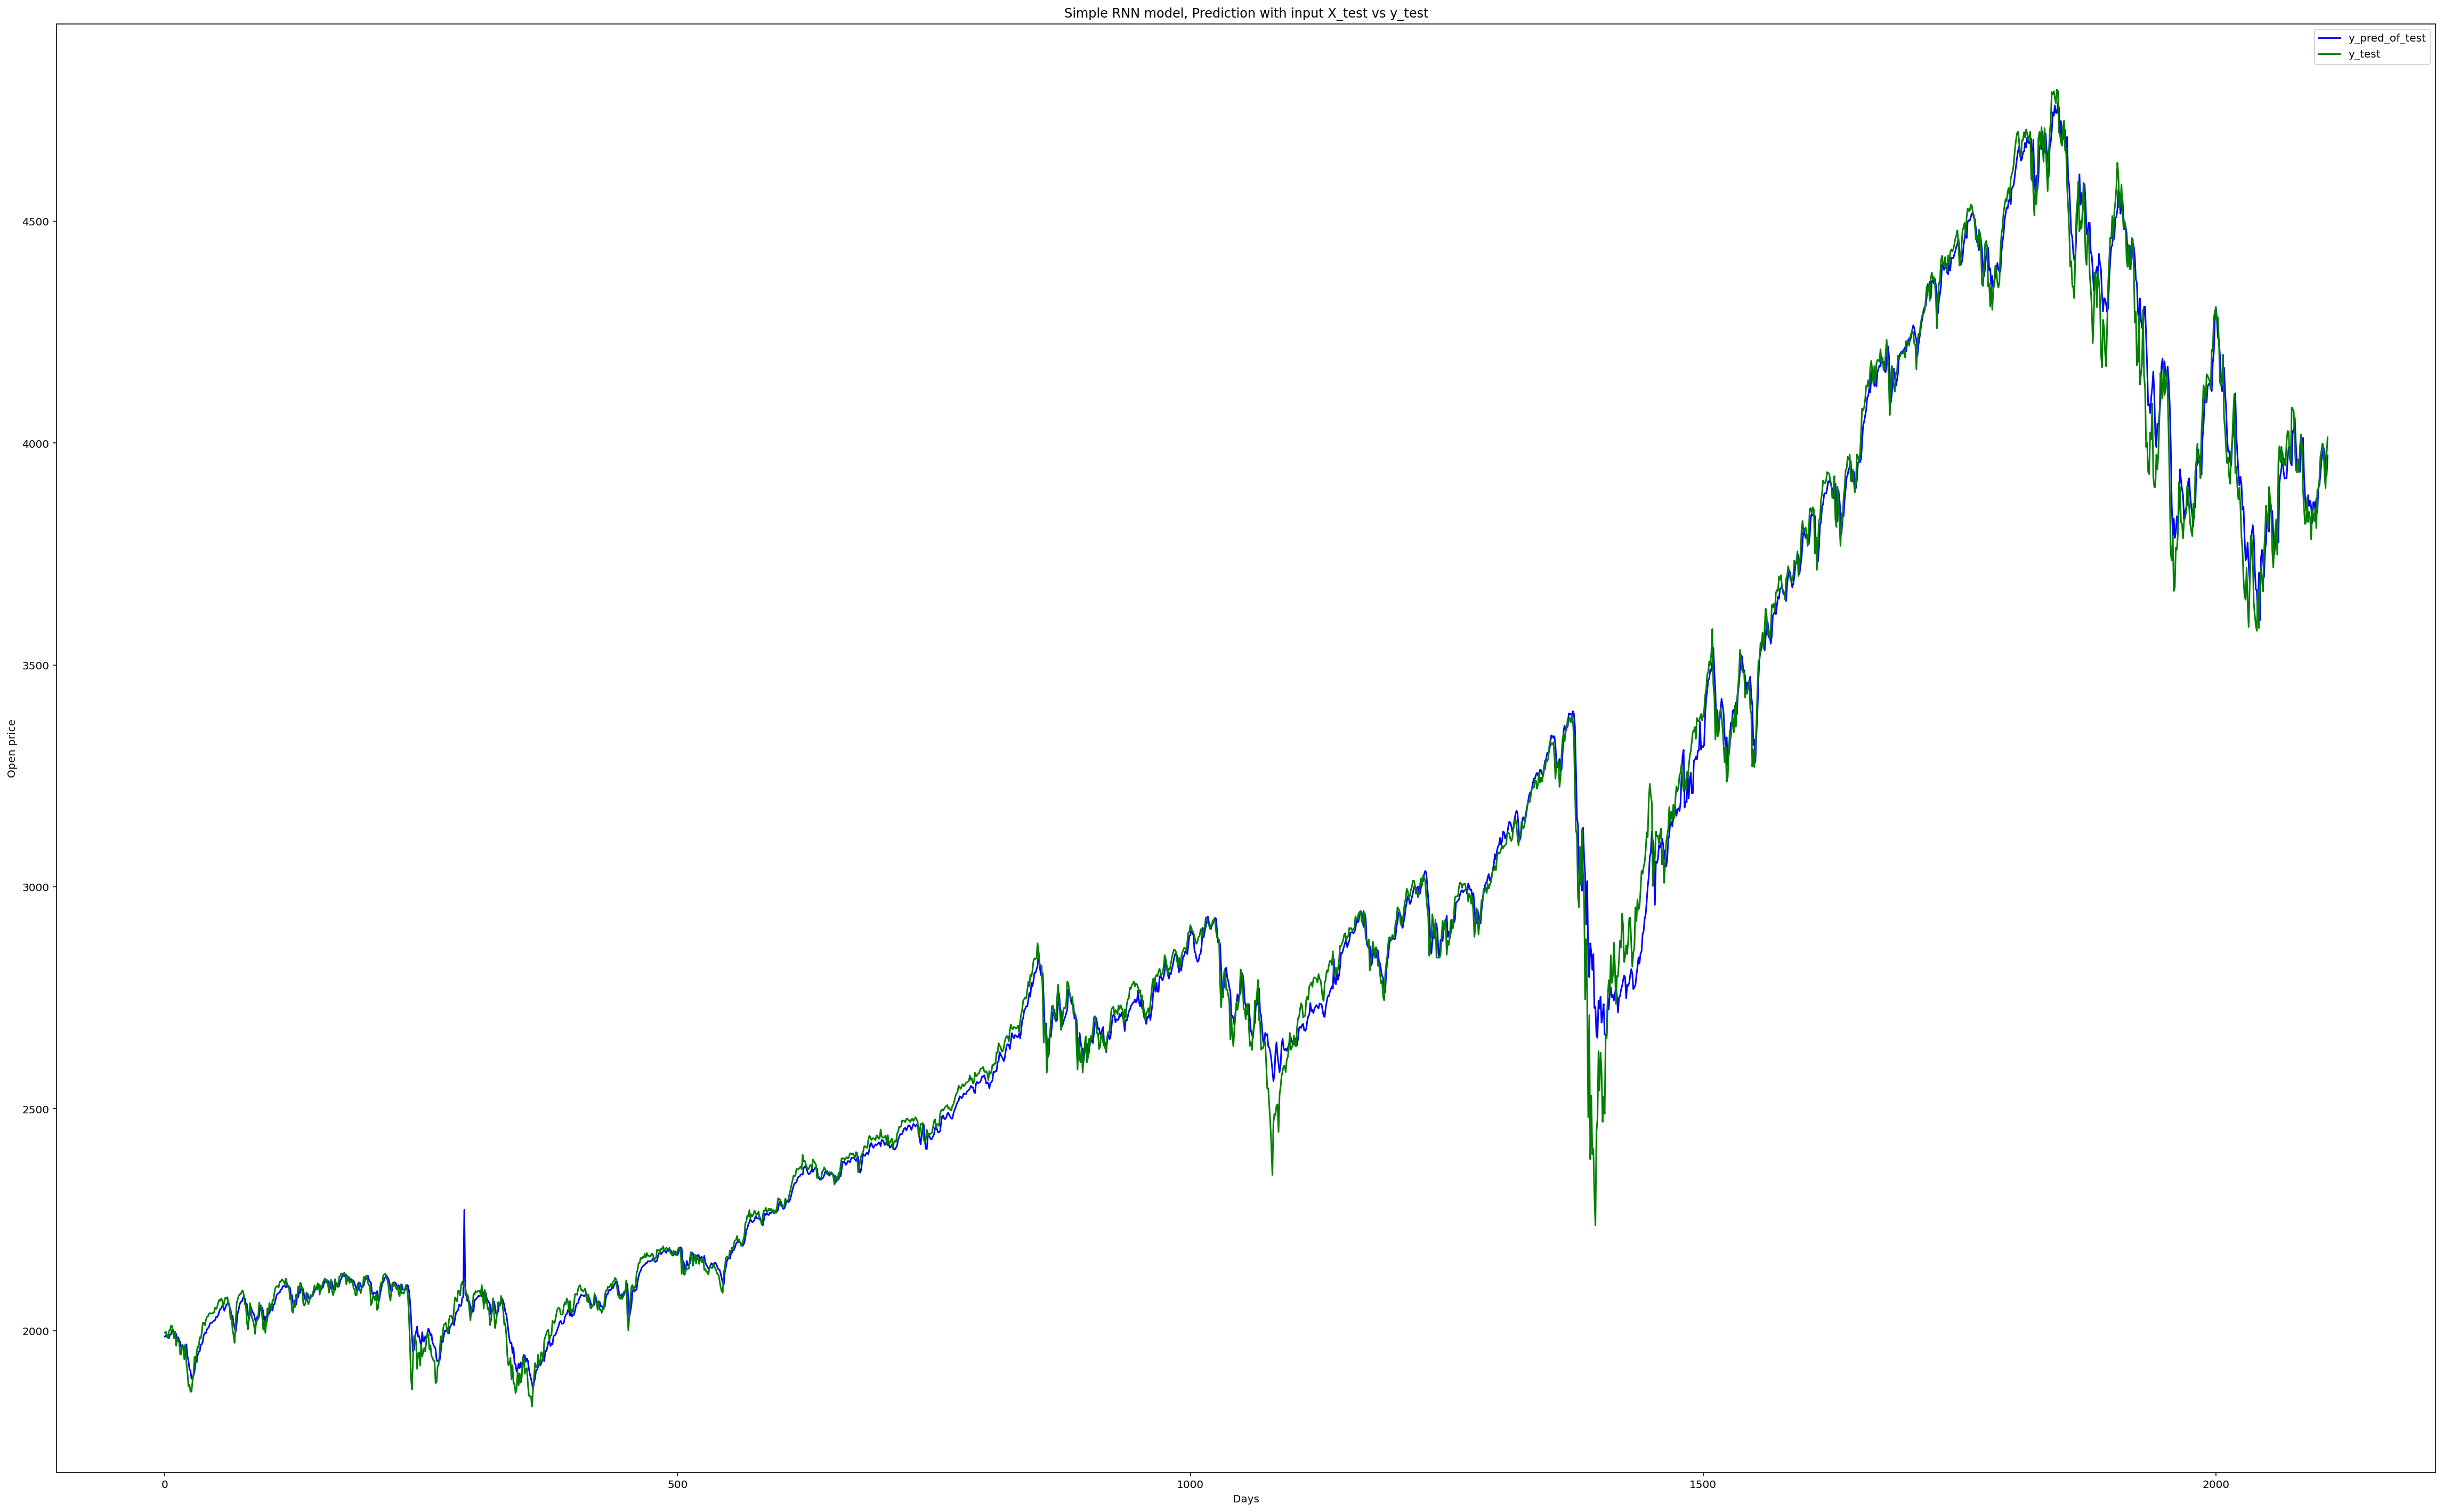

In [768]:
plt.figure(figsize = (40,25))
plt.plot(y_pred_on_test, label = "y_pred_of_test", c = "blue")
plt.plot(y_test, label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [769]:
y_test.shape[0]/5

422.0

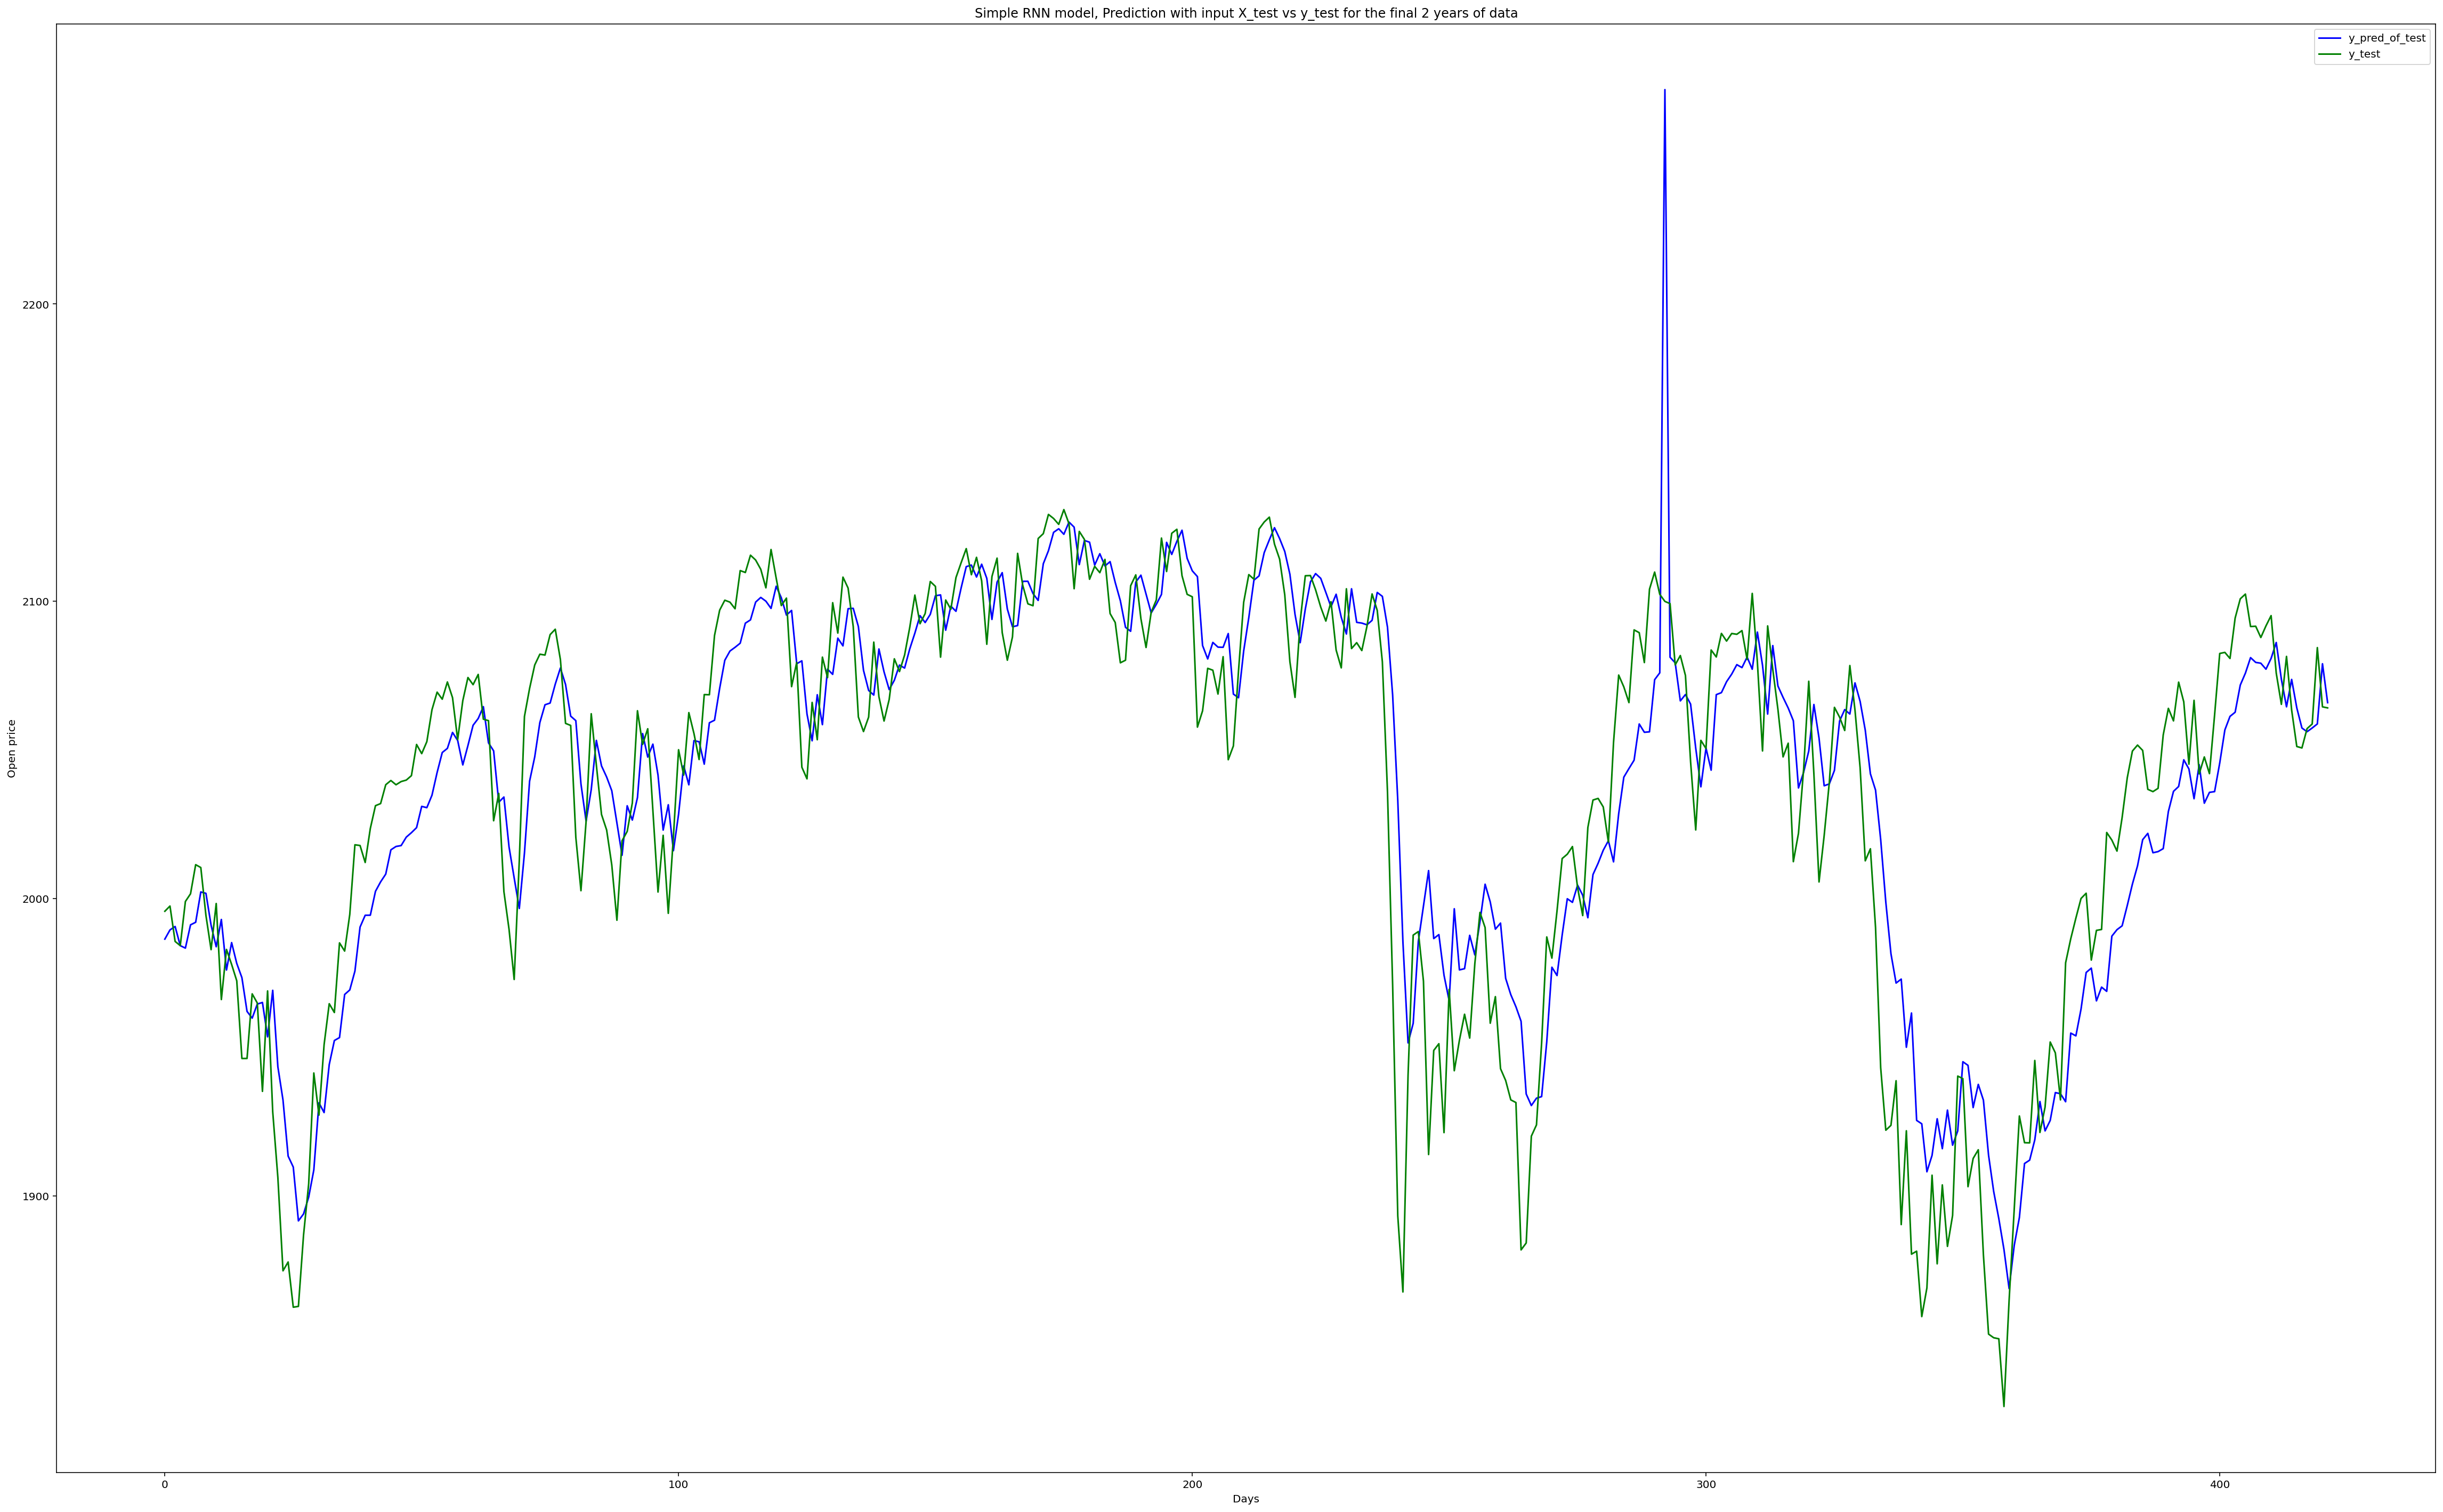

In [770]:
plt.figure(figsize = (40,25))
plt.plot(y_pred_on_test[:422], label = "y_pred_of_test", c = "blue")
plt.plot(y_test[:422], label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test for the final 2 years of data")
plt.legend()
plt.show()

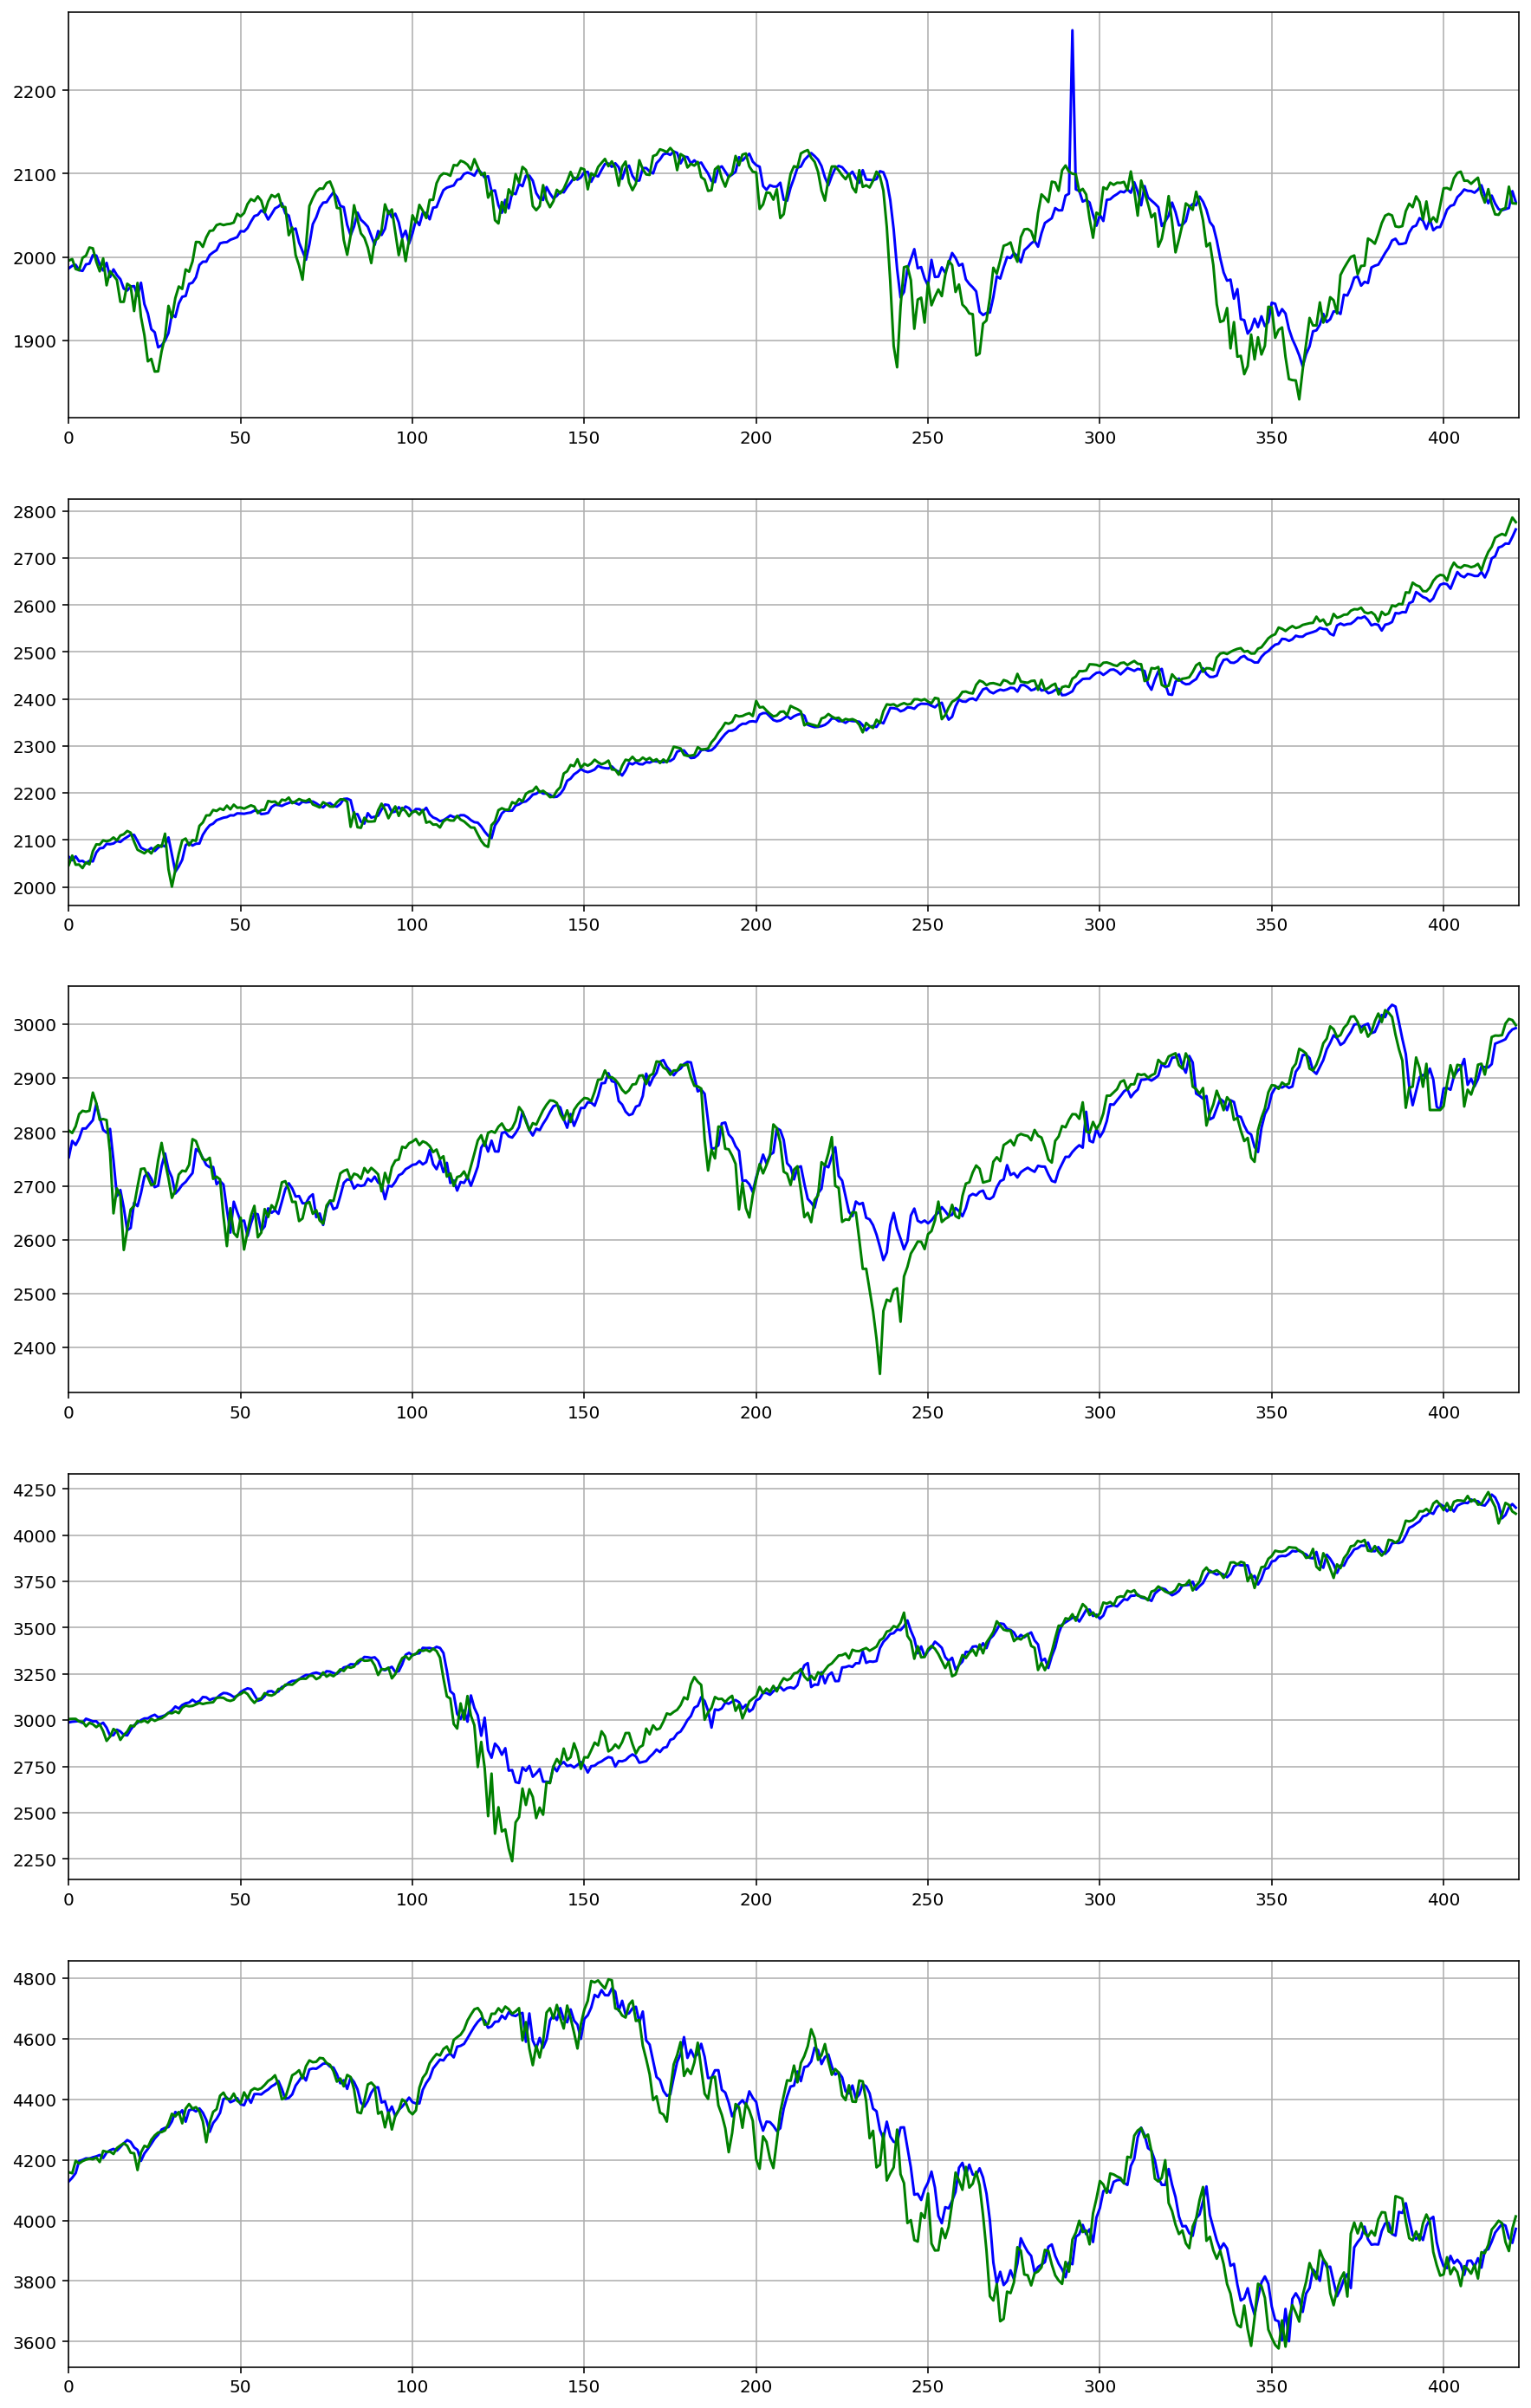

In [771]:
# Create 1 subplot for every "2" years
fig, ax = plt.subplots(5, figsize = (15,25))

for i in range(5):
    ax[i].plot(y_pred_on_test[i * 422: (i + 1) * 422], label = "y_pred_of_test", c = "blue")
    ax[i].plot(y_test[i * 422: (i + 1) * 422], label = "y_test", c = "g")
    ax[i].grid(True)
    ax[i].set_xlim([0,422])


# Strategy 1

The strategy is that if the predicted value for today is higher than the close value for the previous day, then we buy in the morning, and then we will automatically sell at what the close price for that day is.


In [772]:
# Create DF to compare the actual prices and the predicted prices
df_predicted = pd.DataFrame(y_pred_on_test, columns = ['Predicted Close'])
df_actual = pd.DataFrame(y_test, columns = ['Actual Close'])

In [773]:
df_store = pd.DataFrame.join(df_actual, df_predicted, how = 'left')

In [774]:
df_from_pred = df[['open']][8689:]
df_from_pred = df_from_pred.reset_index()

In [775]:
df_from_pred = df_from_pred.drop('Date', axis=1)
df_store = pd.merge(df_store, df_from_pred, left_index = True, right_index = True)

In [776]:
df_store

,Actual Close,Predicted Close,open
0,1995.69,1986.323710,2000.73
1,1997.45,1989.407957,1988.41
2,1985.54,1990.575004,1992.85
3,1984.13,1984.128842,1996.74
4,1998.98,1983.294075,1986.04
...,...,...,...
2105,3990.97,3988.429929,3960.60
2106,3928.86,3982.811084,3999.28
2107,3898.85,3942.351827,4002.25
2108,3972.61,3925.746191,3911.84


In [777]:
# We shift down by one, as our "buy" signal is when the predicted close for the next day, is higher than the current
df_store['Predicted Close'] = df_store['Predicted Close'].shift(-1)
df_store.rename(columns = {'Predicted Close': 'Predicted Close d+1'}, inplace = True)

In [778]:
df_store = df_store.dropna()

In [779]:
df_store.head()

,Actual Close,Predicted Close d+1,open
0,1995.69,1989.407957,2000.73
1,1997.45,1990.575004,1988.41
2,1985.54,1984.128842,1992.85
3,1984.13,1983.294075,1996.74
4,1998.98,1991.119946,1986.04


In [780]:
# Create an empty column to store the signal
df_store['signal'] = np.nan

# Sets the signal, if the prediction for the next day is greater than the current close, then assign 1.
for i in range(len(df_store)):
    if (df_store.iloc[i][1] - df_store.iloc[i][2]) >= 0:
        df_store['signal'].iloc[i] = 1
    else:
        df_store['signal'].iloc[i] = -1

/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_12239/3547608008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store['signal'] = np.nan
/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_12239/3547608008.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store['signal'].iloc[i] = -1
/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_12239/3547608008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

# Test strategy

In [819]:
# Create a copy table
df_results = df_store.copy()

#Create empty col

df_results['strat returns'] = np.nan
df_results['strat returns'].iloc[0] = 0

for i in range(1, len(df_store)-1):
    if df_results['signal'].iloc[i] > 0:
        # In this run through we will use the open value 
        df_results['strat returns'].iloc[i] = df_results['Actual Close'].iloc[i] - df_results['open'].iloc[i]
    elif df_results['signal'].iloc[i] < 0:
        df_results['strat returns'].iloc[i] = 0
#     df_results['investment'].iloc[i] = df_results['investment'].iloc[i-1] * (1 + (df_results['p/l'].iloc[i] / df_results['Actual Close'].iloc[i - 1]))

In [820]:
df_results['return'] = df_results['Actual Close'] - df_results['Actual Close'].shift(1)

In [826]:
df_results

,Actual Close,Predicted Close d+1,open,signal,strat returns,return,strat relative change
0,1995.69,1989.407957,2000.73,-1.0,0.00,0.00,1.000000
1,1997.45,1990.575004,1988.41,1.0,9.04,1.76,1.004526
2,1985.54,1984.128842,1992.85,-1.0,0.00,-11.91,1.000000
3,1984.13,1983.294075,1996.74,-1.0,0.00,-1.41,1.000000
4,1998.98,1991.119946,1986.04,1.0,12.94,14.85,1.006473
...,...,...,...,...,...,...,...
2104,3999.09,3988.429929,3977.57,1.0,21.52,15.92,1.005381
2105,3990.97,3982.811084,3960.60,1.0,30.37,-8.12,1.007610
2106,3928.86,3942.351827,3999.28,-1.0,0.00,-62.11,1.000000
2107,3898.85,3925.746191,4002.25,-1.0,0.00,-30.01,1.000000


In [840]:
df_results['strat relative change'] = (df_results['strat returns'] / df_results['Actual Close'])
df_results['buy hold relative change'] = (df_results['return'] / df_results['Actual Close'].shift(1))

In [837]:
df_results['return'].iloc[0] = 0
df_results.dropna()

,Actual Close,Predicted Close d+1,open,signal,strat returns,return,strat relative change,buy hold relative change
1,1997.45,1990.575004,1988.41,1.0,9.04,1.76,1.004526,0.000882
2,1985.54,1984.128842,1992.85,-1.0,0.00,-11.91,1.000000,-0.005963
3,1984.13,1983.294075,1996.74,-1.0,0.00,-1.41,1.000000,-0.000710
4,1998.98,1991.119946,1986.04,1.0,12.94,14.85,1.006473,0.007484
5,2001.57,1991.985598,1981.93,1.0,19.64,2.59,1.009812,0.001296
...,...,...,...,...,...,...,...,...
2103,3983.17,3974.557926,3932.35,1.0,50.82,13.56,1.012759,0.003416
2104,3999.09,3988.429929,3977.57,1.0,21.52,15.92,1.005381,0.003997
2105,3990.97,3982.811084,3960.60,1.0,30.37,-8.12,1.007610,-0.002030
2106,3928.86,3942.351827,3999.28,-1.0,0.00,-62.11,1.000000,-0.015563


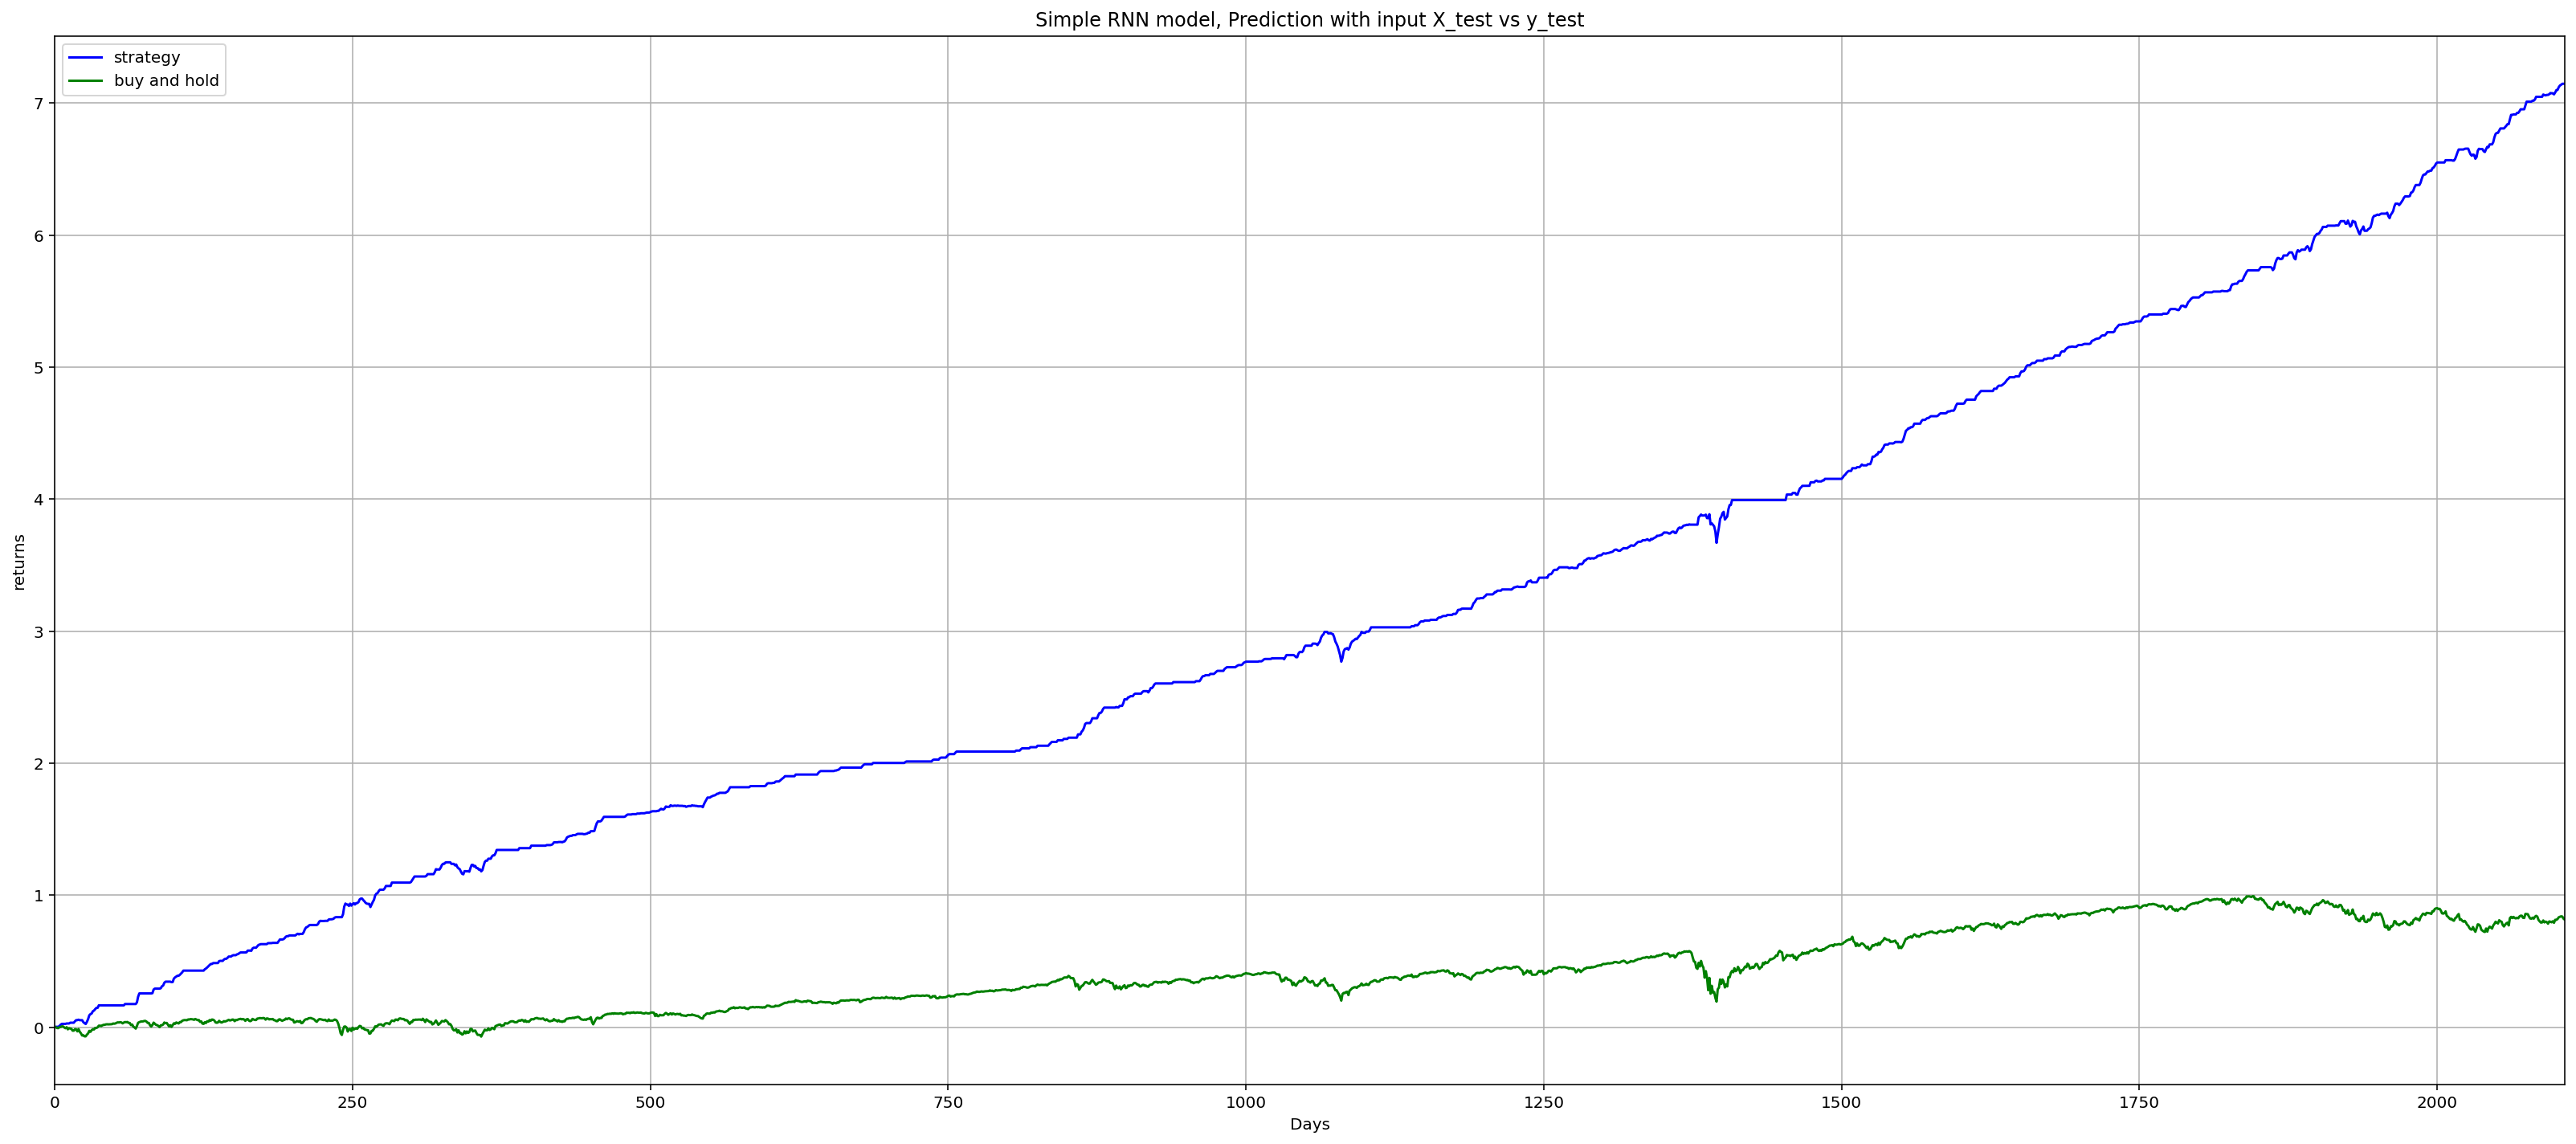

In [863]:
plt.figure(figsize = (28, 12))
plt.plot(df_results['strat relative change'].cumsum(), label = 'strategy', c = "blue")
plt.plot(df_results['buy hold relative change'].cumsum(), label = "buy and hold", c = "g")
plt.xlabel("Days")
plt.ylabel("returns")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend(loc = 'upper left')
plt.grid(True)
plt.xlim([0,2107])
plt.show()

In [849]:
print('10 year return applying strategy:', 1 + df_results['strat relative change'].sum())
print('10 year return buy and hold:', 1 + df_results['buy hold relative change'].sum())

10 year return applying strategy: 8.14586078277396
10 year return buy and hold: 1.8349022784234872


In [848]:
# Invest 100,000 ~ 10 years ago
print(100000 * (1 + df_results['strat relative change'].sum()))
print(100000 * (1 + df_results['buy hold relative change'].sum()))

814586.078277396
183490.22784234872


In [851]:
df_results['strat relative change'].sum() / df_results['buy hold relative change'].sum()

8.558918771029354

In [652]:
df_results.to_csv('output.csv')

# Backtesting the strategy

In [896]:
df.shape

(10799, 13)

In [897]:
X_test_6 = X_train[5 * 422: 6 * 422]
y_test_6 = model.predict(X_test_6)

14/14 [==============================] - 0s 7ms/step


In [898]:
# create empty table with 13 fields
y_test_pred_dataset_like = np.zeros(shape=(len(y_test_6), 13))

# put the predicted values in the right field
y_test_pred_dataset_like[:,0] = y_test_6[:,0]
# inverse transform and then select the right field
y_test_6 = scaler.inverse_transform(y_test_pred_dataset_like)[:,0]

y_test_6 = np.reshape(y_test_6,(-1,1))

print(y_pred_on_test.shape)

(2110, 1)


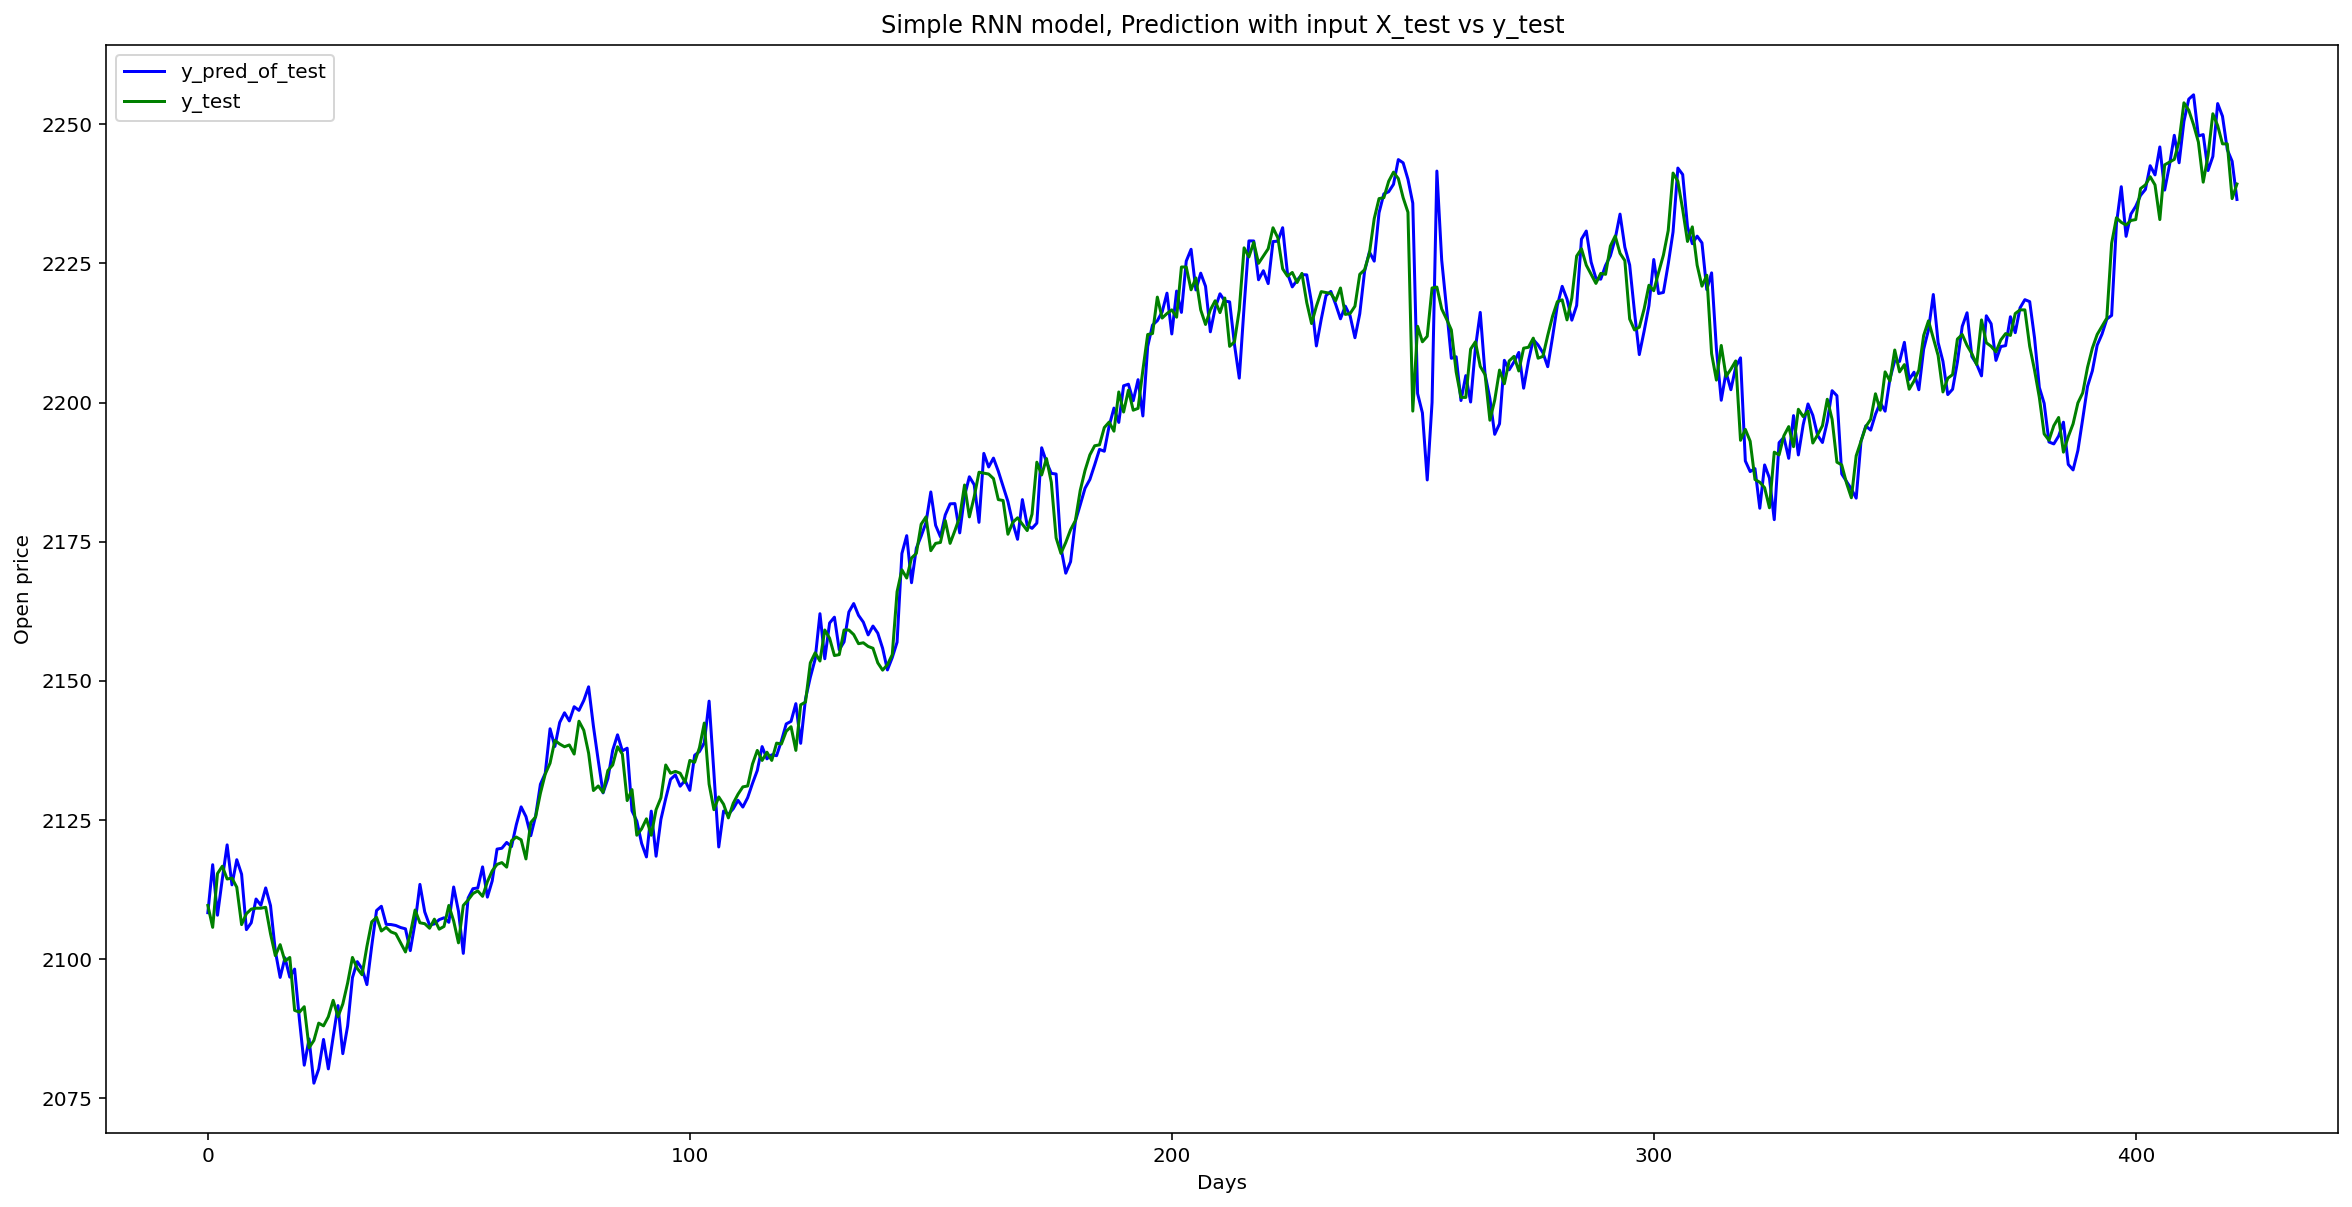

In [899]:
plt.figure(figsize = (20, 10))
plt.plot(y_test_6, label = "y_pred_of_test", c = "blue")
plt.plot(y_train[5 * 422:6 * 422], label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [911]:
# Create DF to compare the actual prices and the predicted prices
df_predicted = pd.DataFrame(y_test_6, columns = ['Predicted Close'])
df_actual = pd.DataFrame(y_train[5 * 422: 6 * 422], columns = ['Actual Close'])

In [912]:
df_store = pd.DataFrame.join(df_actual, df_predicted, how = 'left')

In [913]:
df_store.head()

,Actual Close,Predicted Close
0,2109.664798,2108.362118
1,2105.732984,2116.984911
2,2115.398694,2107.912183
3,2116.709299,2114.440704
4,2114.415741,2120.547232


In [914]:
df_from_pred = df[['open']][5 * 422:6 * 422]
df_from_pred = df_from_pred.reset_index()

In [915]:
df_from_pred = df_from_pred.drop('Date', axis=1)
df_store = pd.merge(df_store, df_from_pred, left_index = True, right_index = True)

In [916]:
df_store.head()

,Actual Close,Predicted Close,open
0,2109.664798,2108.362118,271.9
1,2105.732984,2116.984911,271.1
2,2115.398694,2107.912183,270.0
3,2116.709299,2114.440704,266.5
4,2114.415741,2120.547232,261.9


# Strategy 2

In this strategy, we will buy at open if the prediction is that the price is higher than the open price, then while holding, we will sell at close if the next days prediction is negative